In [ ]:
# !pip install datawig
# !pip install catboost
# !pip install featexp

In [219]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [220]:
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" "/content/kaggle.json"
!mkdir ~/.kaggle/
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c spaceship-titanic
!unzip spaceship-titanic.zip

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  spaceship-titanic.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


# Загрузка библиотек

In [221]:
import math
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(8, 4)})
sns.color_palette("pastel")
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
# from featexp import get_univariate_plots
# from featexp import get_trend_stats
# from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Lasso

In [223]:
train_dataframe = pd.read_csv('/content/train.csv')
test_dataframe = pd.read_csv('/content/test.csv')
submission = pd.read_csv("/content/sample_submission.csv")
df = pd.concat([train_dataframe, test_dataframe], axis=0).reset_index(drop=True)
print('train_dataframe', train_dataframe.shape)
print('test_dataframe', test_dataframe.shape)
print('df', df.shape)

train_dataframe (8693, 14)
test_dataframe (4277, 13)
df (12970, 14)


#  О данных:

   * PassengerId - Уникальный идентификатор для каждого пассажира.
   * HomePlanet - Планета, с которой вылетел пассажир, как правило, планета их постоянного проживания.
   * CryoSleep - Указывает, решил ли пассажир быть переведен в режим анабиоза на время рейса.
   * Cabin - Номер каюты, в которой находится пассажир.
   * Destination - Планета, на которую будет высаживаться пассажир.
   * Age - Возраст пассажира.
   * VIP - Оплатил ли пассажир специальное VIP-обслуживание во время рейса.
   * RoomService - Сумма, выставленная пассажиром за обслуживание номеров.
   * FoodCourt - Сумма, выставленная пассажиром в фуд-корте.
   * ShoppingMall - Сумма, выставленная пассажиром в торговом центре.
   * Spa - Сумма, выставленная пассажиром в спа-салоне.
   * VRDeck - Сумма, выставленная пассажиром на палубе виртуальной реальности.
   * Name - Имя пассажира.
   * Transported - Перенесся ли пассажир в другое измерение.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


train_data.shape (12970, 14)


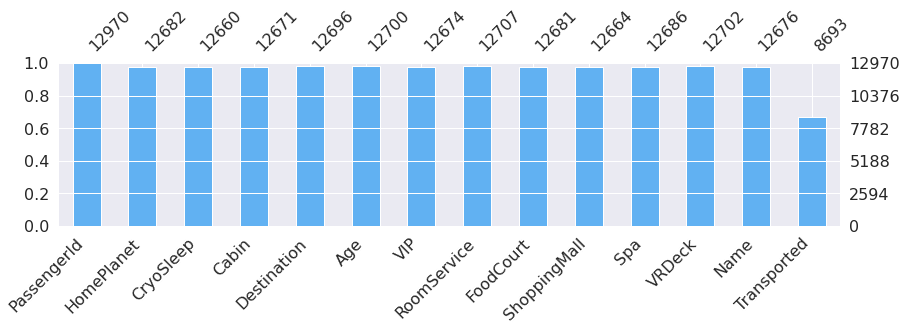

In [ ]:
print('train_data.shape', df.shape)
missing_values = msno.bar(df, figsize = (14,3), color = "#61b1f2")

# Featureengineering

In [ ]:
def feature_engineering(df):
    def fix_5500(df):
        if df > 5500:
            return 5500
        else:
            return df
    def fix_12500(df):
        if df > 12500:
            return 12500
        else:
            return df
    def fix_22000(df):
        if df > 22000:
            return 22000
        else:
            return df

    ### PassengerId
    df['id_group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
    df['passenger_num'] = df['PassengerId'].apply(lambda x: x.split('_')[1]).astype(int)
    df = pd.merge(df, df[['id_group', 'PassengerId']].groupby('id_group').count().reset_index().rename(columns={'PassengerId': 'group_size'}), how='left', on='id_group')
    df = df.drop('PassengerId', axis=1)    
  
    ### Name
    df['Name'] = df['Name'].fillna('Unknown Unknown')
    def last_name(x):
        try:
            if x == type(float):
                return np.NaN
            else:
                return x.split(" ")[1]
        except:
            return np.NaN  

    df['last_name'] = df['Name'].apply(last_name).astype(str)
    df['last_name_len'] = df['last_name'].map(lambda x: len(x))
    df['name_len'] = df['Name'].map(lambda x: len(x))
    df['family_group'] = df.groupby(['id_group'])['last_name'].transform('count')
    df = df.drop('id_group', axis=1)
    df = df.drop('Name', axis=1)
    df = df.drop('last_name', axis=1)
  
    ### Total_bill
    def to_bool_5500(df):
        if df == 5500:
            return 1
        else:
            return 0
    def to_bool_12500(df):
        if df == 12500:
            return 1
        else:
            return 0
    df['RoomService'] = df['RoomService'].fillna(0).apply(fix_5500)
    df['RoomService_bool'] = df['RoomService'].apply(to_bool_5500)

    df['FoodCourt'] = df['FoodCourt'].fillna(0).apply(fix_12500)
    df['FoodCourt_bool'] = df['FoodCourt'].apply(to_bool_12500)

    df['ShoppingMall'] = df['ShoppingMall'].fillna(0).apply(fix_5500)
    df['ShoppingMall_bool'] = df['ShoppingMall'].apply(to_bool_5500)

    df['Spa'] = df['Spa'].fillna(0).apply(fix_12500)
    df['Spa_bool'] = df['Spa'].apply(to_bool_12500)

    df['VRDeck'] = df['VRDeck'].fillna(0).apply(fix_12500)
    df['VRDeck_bool'] = df['VRDeck'].apply(to_bool_12500)

    def to_bool_22000(df):
        if df == 22000:
            return 1
        else:
            return 0
    df['total'] = (df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']).apply(fix_22000)
    df['total_bool'] = df['total'].apply(to_bool_22000)

    def paid_to_family(df):
        if df == 22000:
            return 1
        else:
            return 0
    df['paid_to_family'] = df['total'].apply(paid_to_family)

    df['Cabin'] = df['Cabin'].fillna('Unknown/2000/Unknown')
    df['Cabin_deck'] = df['Cabin'].apply(lambda x: x.split('/')[0]).astype(str)
    df['Cabin_num'] = df['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
    df['Cabin_deck_group'] = pd.cut(x=df['Cabin_num'], bins=[-1, 3, 107, 295, 342, 343, 354, 609, 1508], 
                                    labels=['1', '2', '3', '4', '5', '6', '7', '8']).astype(str)
    df['Cabin_side'] = df['Cabin'].apply(lambda x: x.split('/')[2]).astype(str)
    df['Cabin_len'] = df['Cabin'].apply(lambda x: len(x)).astype(int)
    df = df.drop('Cabin', axis=1)
    df = df.drop('Cabin_deck', axis=1)


    ### Age
    df['Age'] = df['Age'].fillna(df['Age'].mean()-5)
    df['Age_group'] = pd.cut(x=df['Age'], bins=[-1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 75, 100], 
                             labels=['0-5', '6-10', '11-15', '16-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-75', '76-100']).astype(str)
    df = df.drop('Age', axis=1)
            

    ### HomePlanet
    df['HomePlanet'] = df['HomePlanet'].fillna(method='ffill')

    ### CryoSleep
    df['CryoSleep'] = df['CryoSleep'].fillna(method='ffill').astype(int)

    ### Destination
    df['Destination'] = df['Destination'].fillna(method='ffill')
  
    ### VIP
    df['VIP'] = df['VIP'].fillna(method='ffill').astype(int)

    return df

In [ ]:
df = feature_engineering(df)

In [ ]:
train_dataframe = df[df['Transported'].notnull()]
test_dataframe = df[df['Transported'].isnull()]
print('train_dataframe', train_dataframe.shape)
print('test_dataframe', test_dataframe.shape)

train_dataframe (8693, 28)
test_dataframe (4277, 28)


In [ ]:
feats_cat = []
feats_num = []
for col in train_dataframe.columns:
    if col in ['PassengerId', 'Transported']:
        continue
    if train_dataframe[col].dtype == 'object':
        feats_cat += [col]
    else:
        feats_num += [col]
        
X_cat = pd.get_dummies(train_dataframe[feats_cat])
X_num = train_dataframe[feats_num]
X_pred_cat = pd.get_dummies(test_dataframe[feats_cat])
X_pred_num = test_dataframe[feats_num]

X = pd.concat([X_cat, X_num], axis=1)
y = train_dataframe['Transported'].astype(int)
X_pred = pd.concat([X_pred_cat, X_pred_num], axis=1)

print('X', X.shape)
print('y', y.shape)
print('X_pred', X_pred.shape)

X (8693, 51)
y (8693,)
X_pred (4277, 51)


#  StandardScaler

In [ ]:
# Усреднение и масштабирование данных
col_names = list(X.columns)
s_scaler = StandardScaler()
X_scaled= s_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=col_names)
# X_scaled.describe().T

In [ ]:
X_pred_scaled= s_scaler.fit_transform(X_pred)
X_pred_scaled = pd.DataFrame(X_pred_scaled, columns=col_names)   
# X_pred_scaled.describe().T

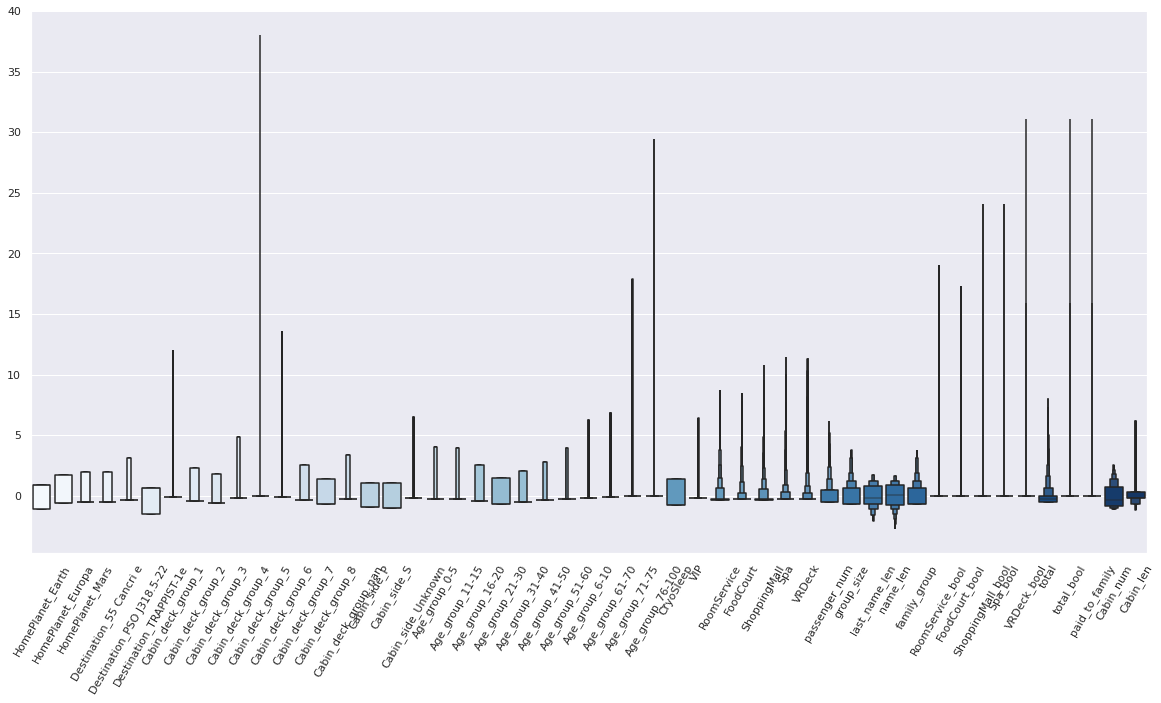

In [ ]:
# boxplot
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_scaled,palette = 'Blues')
plt.xticks(rotation=60)
plt.show()

#train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4, random_state=1)

# Выбор модели

In [ ]:
# Построение пайплайнов модели для различных классификаторов

pipeline_lr = Pipeline([('lr_classifier', LogisticRegression())])

pipeline_gbcl = Pipeline([('gbcl_classifier', GradientBoostingClassifier())])

pipeline_rfc = Pipeline([('rf_classifier', RandomForestClassifier())])

pipeline_knn = Pipeline([('knn_classifier', KNeighborsClassifier())])

pipeline_svc = Pipeline([('svc_classifier', SVC())])

pipeline_catboost_c = Pipeline([('catboost_classifier', CatBoostClassifier(silent=True))])



# Список всех пайплайнов
pipelines = [pipeline_lr, 
             pipeline_gbcl,
             pipeline_rfc,
             pipeline_knn,
             pipeline_svc,
             pipeline_catboost_c,]

# Словарь конвейеров и типов классификаторов для удобства поиска
pipe_dict = {0: 'LogisticRegression', 
             1: 'GradientBoostingClassifier', 
             2: 'RandomForestClassifier',
             3: 'KNeighborsClassifier', 
             4: 'Support Vector Machines', 
             5: 'CatBoostClassifier',}


# Обучение моделей
for pipe in pipelines:
    pipe.fit(X_train, y_train)

cv_results_accuracy = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train, cv=5)
    cv_results_accuracy.append(cv_score)
    print(pipe_dict[i], cv_score.mean())

LogisticRegression 0.773346116970278
GradientBoostingClassifier 0.7990412272291465
RandomForestClassifier 0.7877277085330777
KNeighborsClassifier 0.7652924256951102
Support Vector Machines 0.7848513902205178
CatBoostClassifier 0.8030680728667307


# Grid Search CV

In [ ]:
# Выбор лучших параметров
parameters = {"learning_rate": [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1], 
              "n_estimators": [50, 100, 200, 350, 500],
              "max_depth": range(2, 10, 2)
              }

GridSearchCV_gbcl = GridSearchCV(estimator = GradientBoostingClassifier(), 
                                param_grid = parameters, 
                                cv = 5,
                                verbose = 1, 
                                n_jobs = -1,
                                scoring = "accuracy", 
                                return_train_score = True
                                )

GridSearchCV_gbcl.fit(X_train, y_train);
best_parameters = GridSearchCV_gbcl.best_params_
print(f"Лучшие параметры для модели:\n{best_parameters}")

Fitting 5 folds for each of 140 candidates, totalling 700 fits
Лучшие параметры для модели:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


# Predict

In [ ]:
# Тестирование с лучших параметров
gbcl = GradientBoostingClassifier(criterion="friedman_mse", 
                                  learning_rate=0.02, 
                                  loss="deviance", 
                                  max_depth=, 
                                  max_features="sqrt", 
                                  min_samples_leaf=0.3, 
                                  min_samples_split=8, 
                                  n_estimators=50, 
                                  random_state=42)

gbcl_mod = gbcl.fit(X_train, y_train)
pred_gbcl = gbcl_mod.predict(X_test)

score_gbcl_train = gbcl_mod.score(X_train, y_train)
score_gbcl_test = gbcl_mod.score(X_test, y_test)

In [ ]:
print(f"r^2 на обучающей выборке = {round(score_gbcl_train, 3)}")
print(f"r^2 на тестовой выборке = {round(score_gbcl_test, 3)}")

r^2(коэффициент детерминации) на обучающей выборке = 0.859
r^2(коэффициент детерминации) на тестовой выборке = 0.799


In [ ]:
pred_gbcl = pipeline_gbcl.predict(X_test)
accuracy = accuracy_score(y_test, pred_gbcl)
print(f" Тестовая оценка модели {accuracy}")


 Тестовая оценка модели 0.8010350776308223


In [ ]:
# Получение отчета о классификации
print(classification_report(y_test, pred_gbcl))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1730
           1       0.78      0.84      0.81      1748

    accuracy                           0.80      3478
   macro avg       0.80      0.80      0.80      3478
weighted avg       0.80      0.80      0.80      3478



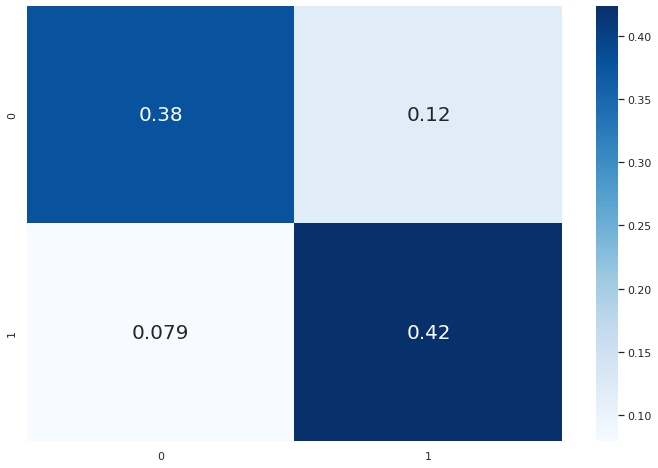

In [ ]:
# Получение матрицы
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, pred_gbcl)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap='Blues',annot = True, annot_kws = {'size':20})
plt.show()